# Quick Start

A simple example how define a BO problem in BayBE and use the simulation utility to create a backtesting plot.

Find more information here:
- [Simple Campaign Example](https://emdgroup.github.io/baybe/examples/Basics/campaign.html)
- [Backtesting Examples](https://emdgroup.github.io/baybe/examples/Backtesting/Backtesting.html)
- [BayBE GitHub](https://github.com/emdgroup/baybe)
- [BayBE Userguide](https://emdgroup.github.io/baybe/userguide/userguide.html)

<a target="_blank" href="https://colab.research.google.com/github/emdgroup/baybe-ac24-workshop/blob/main/1_Quick_Start.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<a target="_blank" href="https://mybinder.org/v2/gh/emdgroup/baybe-ac24-workshop/HEAD?labpath=1_Quick_Start.ipynb">
  <img src="https://mybinder.org/badge_logo.svg" alt="Launch Binder"/>
</a>

# Install and Import

In [ ]:
!pip install 'baybe[simulation]==0.10.0' seaborn matplotlib

In [ ]:
import warnings
from botorch.exceptions import InputDataWarning
warnings.filterwarnings('ignore', category = InputDataWarning)
warnings.filterwarnings('ignore', message = '.*BayBE.*')

import baybe
baybe.__version__

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

from baybe.utils.random import set_random_seed
set_random_seed(1337)

# Define the Problem Lookup

For utilitzing the simulation utility, a Callable or a pd.DataFrame can be provided.
Here, we define a simple analytical callable which mimics a simple process to be optimized.

In [5]:
def simple_function(x1, x2, x3, x4, x5):
    """This mimics a simple process to be calibrated."""
    
    return (
            0.3*(x1 - 1)**2 
            + 3.0 * x2 
            - 0.4*(x3 + 1)**3 
            - 0.8*(x4 + 2)**2 
            - 0.6 * (x5 - x1)**2 # simple interaction terms
            - 2 * x1 * x3
    )

F_BEST = 545.89999
DIMENSION = 5
BOUNDS = (-10, 10)

# Setup the Problem Components

### Search Space

In [6]:
from baybe.parameters import NumericalContinuousParameter
from baybe.searchspace import SearchSpace

# 5 identical continuous parameters
parameters = [
    NumericalContinuousParameter(
        name = f"x_{k+1}",
        bounds = BOUNDS,
    )
    for k in range(DIMENSION)
]

# The search space is the product of the parameters
searchspace = SearchSpace.from_product(parameters=parameters)

### Objective

In [7]:
from baybe.targets import NumericalTarget
from baybe.objectives import SingleTargetObjective

# A simple single-target objective
objective = SingleTargetObjective(
    target = NumericalTarget(
        name = "Target",
        mode = "MAX"
    )
)

### Recommender
We use the meta-recommender `TwoPhaseMetaRecommender` which has two phases:
- For the first query, recommendations will be random
- After the first addition of measurements, recommendations will be according to Botorch's optimizer

We choose the MC-based LogExpectedImprovement as acquisition funciton (which is also the default).

[Read more on recommenders.](https://emdgroup.github.io/baybe/userguide/recommenders.html)

In [8]:
from baybe.acquisition import qLogExpectedImprovement
from baybe.recommenders import (TwoPhaseMetaRecommender,
                                RandomRecommender,
                                BotorchRecommender)

recommender = TwoPhaseMetaRecommender(
    initial_recommender = RandomRecommender(),
    recommender = BotorchRecommender(acquisition_function = qLogExpectedImprovement()),
    switch_after = 1 # default, switches after the frst addition of measurements
)

# Define the Campaigns
We will benchmark two campaigns via backtesting:
- **BO**: Defined according to our configration above
- **Random**: Providing random recommendations as baseline

In [9]:
from baybe.campaign import Campaign

campaign = Campaign(
    searchspace = searchspace,
    objective = objective,
    recommender = recommender
)
campaign_random = Campaign(
    searchspace = searchspace,
    objective = objective,
    recommender = RandomRecommender() # the recommender is the only difference to the other campaign
)

# Run the Simulation

In [10]:
from baybe.simulation import simulate_scenarios

# How often a campaign loop is performed, each time starting with a different random seed
MC_RUNS = 5

# Amount of subsequent recommend-measure iterations done per campaign
DOE_ITERATIONS = 15

# Amount of recommendations received / measurements performed per iteration
BATCH_SIZE = 2

# Dict organizing the campaigns
scenarios = {
    "BO": campaign,
    "Random": campaign_random,
}

# Run the utility for backtesting
results = simulate_scenarios(
    scenarios,
    simple_function,
    batch_size = BATCH_SIZE,
    n_doe_iterations = DOE_ITERATIONS,
    n_mc_iterations = MC_RUNS,
)
results

I0000 00:00:1722726814.751196   23050 work_stealing_thread_pool.cc:320] WorkStealingThreadPoolImpl::PrepareFork
100%|#############################################################################################################################################################################| 10/10 [00:18<00:00,  1.87s/it]


,Scenario,Monte_Carlo_Run,Iteration,Num_Experiments,Target_Measurements,Target_IterBest,Target_CumBest
0,BO,0,0,2,"[-38.481264805001054, -561.5424606614158]",-38.481265,-38.481265
1,BO,0,1,4,"[-53.76717592434244, -21.844581475301933]",-21.844581,-21.844581
2,BO,0,2,6,"[-150.4339083899613, -31.898969627142076]",-31.898970,-21.844581
3,BO,0,3,8,"[-155.13192046280292, -319.50975577161756]",-155.131920,-21.844581
4,BO,0,4,10,"[-56.53720889434915, 17.031553669589506]",17.031554,17.031554
...,...,...,...,...,...,...,...
145,Random,4,10,22,"[-99.03379421029918, 63.812301003318936]",63.812301,274.708044
146,Random,4,11,24,"[-198.833717210471, -269.5582388583611]",-198.833717,274.708044
147,Random,4,12,26,"[207.68384586033613, -278.60764136736094]",207.683846,274.708044
148,Random,4,13,28,"[-63.830898554328634, -92.92324500847083]",-63.830899,274.708044


# Plot the Result

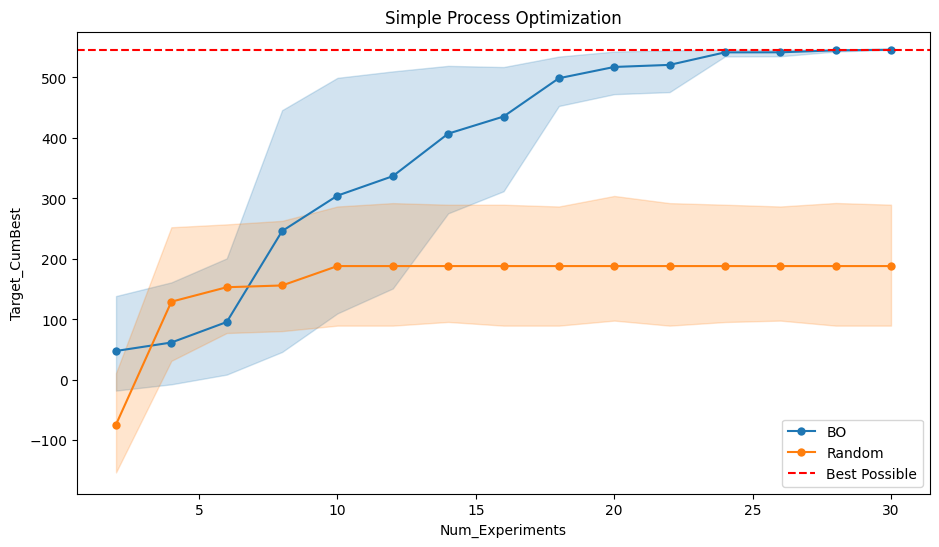

In [13]:
PLOTARGS = {
    'linestyle': 'solid',
    'marker': 'o',
    'markersize': 6, 
    'markeredgecolor': 'none'
}
FIGSIZE = (11,6)

sns.lineplot(data = results, 
             x = "Num_Experiments", 
             y = "Target_CumBest", 
             hue = "Scenario",
             **PLOTARGS)

plt.axhline(y = F_BEST, color = 'red', linestyle='--', label='Best Possible')
plt.gcf().set_size_inches(FIGSIZE)
plt.gca().set_ylim(plt.gca().get_ylim()[0], F_BEST+30)
plt.legend()
plt.title('Simple Process Optimization');